- Summary
- Business Understanding\
   Apple looking to understand positive and negative sentiment around their products and how to improve. Focusing on neutral 
   and negative sentiment tweets as demographics to focus on.
- Data Understanding


In [421]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [422]:
df = pd.read_csv("data/tweet_product_company.csv", encoding = 'latin-1')

In [423]:
df.tail()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


In [424]:
df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [425]:
df['tweet_text_lower'] = df['tweet_text'].str.lower()

In [426]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tweet_text_lower
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,.@wesley83 i have a 3g iphone. after 3 hrs twe...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,@jessedee know about @fludapp ? awesome ipad/i...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,@swonderlin can not wait for #ipad 2 also. the...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,@sxsw i hope this year's festival isn't as cra...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,@sxtxstate great stuff on fri #sxsw: marissa m...


Checking if any Apple terms are in tweet_text to work with all apple related tweets since there are many missing values in
'emotion_in_tweet_is_directed_at'

In [427]:
apple_related = 'ipad|apple|iphone|itunes'

In [428]:
df['tweet_text_lower'].str.contains(apple_related).sum()

5592

In [429]:
df.shape

(9093, 4)

Dropping the one row with missing tweet_text

In [430]:
df.dropna(subset=['tweet_text'], inplace=True)

In [431]:
apple_df = df[df['tweet_text_lower'].str.contains(apple_related)].copy()

In [432]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5592 entries, 0 to 9091
Data columns (total 4 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          5592 non-null   object
 1   emotion_in_tweet_is_directed_at                     2417 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  5592 non-null   object
 3   tweet_text_lower                                    5592 non-null   object
dtypes: object(4)
memory usage: 218.4+ KB


In [433]:
apple_df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              659
iPad or iPhone App                 454
iPhone                             296
Other Apple product or service      35
Android                              9
Android App                          8
Google                               7
Other Google product or service      3
Name: emotion_in_tweet_is_directed_at, dtype: int64

Dropping Columns 'emotion_in_tweet_is_direct_at' because we have focused on all Apple related tweets already and will analyze sentiment from there.

In [434]:
apple_df.drop(columns=['emotion_in_tweet_is_directed_at', 'tweet_text_lower'], axis=1, inplace=True)

In [435]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5592 entries, 0 to 9091
Data columns (total 2 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          5592 non-null   object
 1   is_there_an_emotion_directed_at_a_brand_or_product  5592 non-null   object
dtypes: object(2)
memory usage: 131.1+ KB


In [436]:
apple_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    2929
Positive emotion                      2144
Negative emotion                       420
I can't tell                            99
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [437]:
def custom_encoder(apple_df):
    apple_df.replace(to_replace ="No emotion toward brand or product", value =2, inplace=True)
    apple_df.replace(to_replace ="Positive emotion", value =1, inplace=True)
    apple_df.replace(to_replace ="Negative emotion", value =0, inplace=True)
    apple_df.replace(to_replace ="I can't tell", value =2, inplace=True)

In [438]:
custom_encoder(apple_df['is_there_an_emotion_directed_at_a_brand_or_product'])

In [439]:
apple_df.head()

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,1
3,@sxsw I hope this year's festival isn't as cra...,0
5,@teachntech00 New iPad Apps For #SpeechTherapy...,2


In [440]:
apple_df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product": "emotion"}, inplace=True)

In [441]:
apple_df.head()

,tweet_text,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,1
3,@sxsw I hope this year's festival isn't as cra...,0
5,@teachntech00 New iPad Apps For #SpeechTherapy...,2


In [442]:
apple_df.duplicated().sum()

5

In [443]:
apple_df.drop_duplicates(inplace=True)

In [444]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5587 entries, 0 to 9091
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  5587 non-null   object
 1   emotion     5587 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 130.9+ KB


# Train Test Split

In [445]:
apple_df = apple_df.copy()

In [446]:
from sklearn.model_selection import train_test_split

X = apple_df.drop(columns=['emotion'], axis=1)
y = apple_df['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [447]:
train_sample = X_train.sample(5, random_state=42)
train_sample.style.set_properties(**{'text-align': 'left'})

,tweet_text
5039,RT @mention : Aron Pilhofer from The New York Times just endorsed HTML over iPad at the #NewsApps #sxsw and asked us not to tweet...
3852,@mention is an out-of-town douchebag selling his new ipad 2 above sticker price. {link} #sxsw
5423,RT @mention Apple has opened a pop-up store in Austin so that the nerds in town for #SXSW can get their new iPads. {link}
192,The #iPad 2 Takes Over #SXSW [VIDEO] /by @mention {link}
2911,"To my friends at #SXSW who think I abandoned you, in reality I just didn't have any means of communication, my iPhone stopped working. #fail"


# Wes

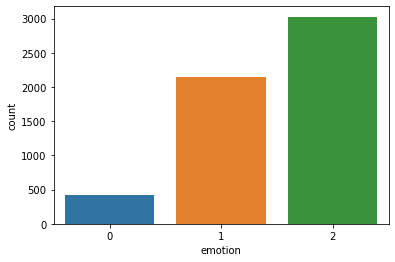

In [448]:
sns.countplot(x='emotion', data=apple_df);

- Emotion is unbalanced target with much fewer negative tweets. (0 is negative, 1 is positive, 2 is neutral/can't tell)

Preprocessing

-Starting with lowercasing

In [449]:
X_train["tweet_text"] = X_train["tweet_text"].str.lower()

In [450]:
X_train.iloc[100]['tweet_text']

'\x89ûï@mention new #ubersocial for #iphone now in the app store includes uberguide to #sxsw sponsored by #mashable\x89û\x9d @mention vamos a probar...'

In [451]:
from nltk.tokenize import RegexpTokenizer

basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)

In [452]:
X_train["text_tokenized"] = X_train["tweet_text"].apply(tokenizer.tokenize)

In [453]:
X_train.iloc[100]["text_tokenized"][:20]

['ûï',
 'mention',
 'new',
 'ubersocial',
 'for',
 'iphone',
 'now',
 'in',
 'the',
 'app',
 'store',
 'includes',
 'uberguide',
 'to',
 'sxsw',
 'sponsored',
 'by',
 'mashable',
 'mention',
 'vamos']

In [454]:
from nltk import FreqDist

train_freq_dist = FreqDist(X_train["text_tokenized"].explode())

In [455]:
from matplotlib.ticker import MaxNLocator

def visualize_top_10(freq_dist, title):
    
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]
    
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)
    
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=45)
    

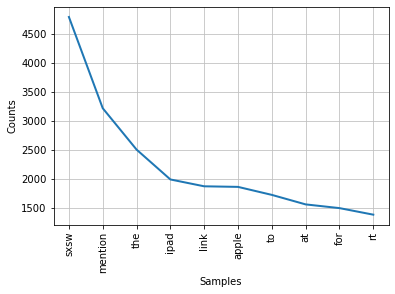

In [456]:
train_freq_dist.plot(10, cumulative=False);

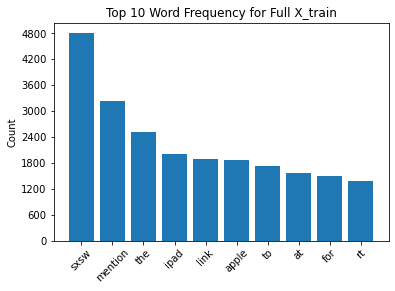

In [457]:
visualize_top_10(train_freq_dist, "Top 10 Word Frequency for Full X_train")

 - Dropping emotion_in_tweet_is_directed_at for now just to analyze tweets and overall sentiment irregardless of brand.

IndexError: list index out of range

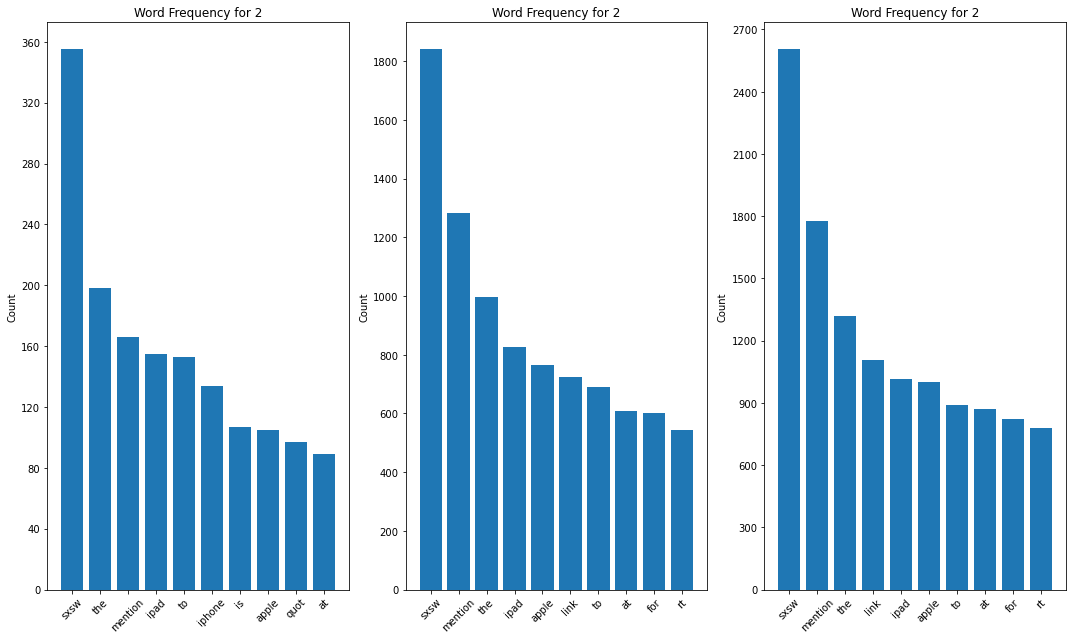

In [458]:
X_train["emotion"] = [y_train[val] for val in X_train.index]

def setup_three_subplots():
    
    fig = plt.figure(figsize=(15,9))
    fig.set_tight_layout(True)
    gs = fig.add_gridspec(1, 6)
    ax1 = fig.add_subplot(gs[0, :2]) # row 0, cols 0-1
    ax2 = fig.add_subplot(gs[0, 2:4])# row 0, cols 2-3
    ax3 = fig.add_subplot(gs[0, 4:]) # row 0, cols 4-5
    return fig, [ax1, ax2, ax3]

def plot_distribution_of_column_by_category(column, axes, title="Word Frequency for"):
    unique_categories = X_train['emotion'].unique()
    
    if len(axes)<len(unique_categories):
        raise ValueError
    
    for index, category in enumerate(X_train.emotion):
        # Calculate frequency distribution for this subset
        all_words = X_train[X_train["emotion"] == index][column].explode()
        freq_dist = FreqDist(all_words)
        top_10 = list(zip(*freq_dist.most_common(10)))
        
        tokens = top_10[0]
        counts = top_10[1]

        # Set up plot
        ax = axes[index]
        ax.bar(tokens, counts)

        # Customize plot appearance
        ax.set_title(f"{title} {category}")
        ax.set_ylabel("Count")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis="x", rotation=45)


fig, axes = setup_three_subplots()
plot_distribution_of_column_by_category("text_tokenized", axes)
fig.suptitle("Word Frequencies for All Tokens", fontsize=24);

In [459]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10)

X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,apple,at,for,ipad,link,mention,rt,sxsw,the,to
0,0.891189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.453632,0.000000,0.000000
1,0.000000,0.292554,0.000000,0.502628,0.000000,0.681696,0.307907,0.136207,0.000000,0.289323
2,0.000000,0.000000,0.724397,0.606089,0.000000,0.000000,0.000000,0.328489,0.000000,0.000000
3,0.000000,0.000000,0.460931,0.000000,0.394898,0.000000,0.000000,0.209016,0.766753,0.000000
4,0.427662,0.000000,0.000000,0.000000,0.000000,0.726329,0.492101,0.217688,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
4464,0.471426,0.515410,0.000000,0.000000,0.000000,0.400329,0.542460,0.239965,0.000000,0.000000
4465,0.000000,0.390823,0.000000,0.000000,0.000000,0.607119,0.000000,0.181960,0.667499,0.000000
4466,0.000000,0.000000,0.000000,0.389231,0.398563,0.703866,0.000000,0.210956,0.386934,0.000000
4467,0.000000,0.000000,0.615496,0.514974,0.527320,0.000000,0.000000,0.279106,0.000000,0.000000


Double checking the shape of vectorized data. Same number of rows and 10 columns because max_features=10

In [460]:
assert X_train_vectorized.shape[0] == X_train.shape[0]
assert X_train_vectorized.shape[1] == 10

Fitting and evaluating a Multinomial Naive Bayes Classifier using cross_val_score as baseline model

In [461]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

baseline_model = MultinomialNB()

baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv.mean()

0.53680903672862

In [462]:
y_train.value_counts(normalize=True)

2    0.536809
1    0.386664
0    0.076527
Name: emotion, dtype: float64

This model appears to guess the majority class of neutral with almost exactly the same accuracy that it appears. 

# Iterate upon the model using different Prepocessing and Feature Engineering

# Removing Stopwords

In [463]:
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

stopwords_list = stopwords.words('english')

Appending stopwords "sxsw" and "mention" because they appear very often because the twitter users are at SXSW and mention is an artifact from the twitter platform.

In [464]:
stopwords_list.append('sxsw')
stopwords_list.append('mention')
stopwords_list.remove('not')

In [465]:
stopwords_list[-3:]

["wouldn't", 'sxsw', 'mention']

# Making a function to remove stopwords and applying it to X_train

In [466]:
def remove_stopwords(token_list):
    
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

In [467]:
X_train["text_without_stopwords"] = X_train["text_tokenized"].apply(remove_stopwords)

IndexError: list index out of range

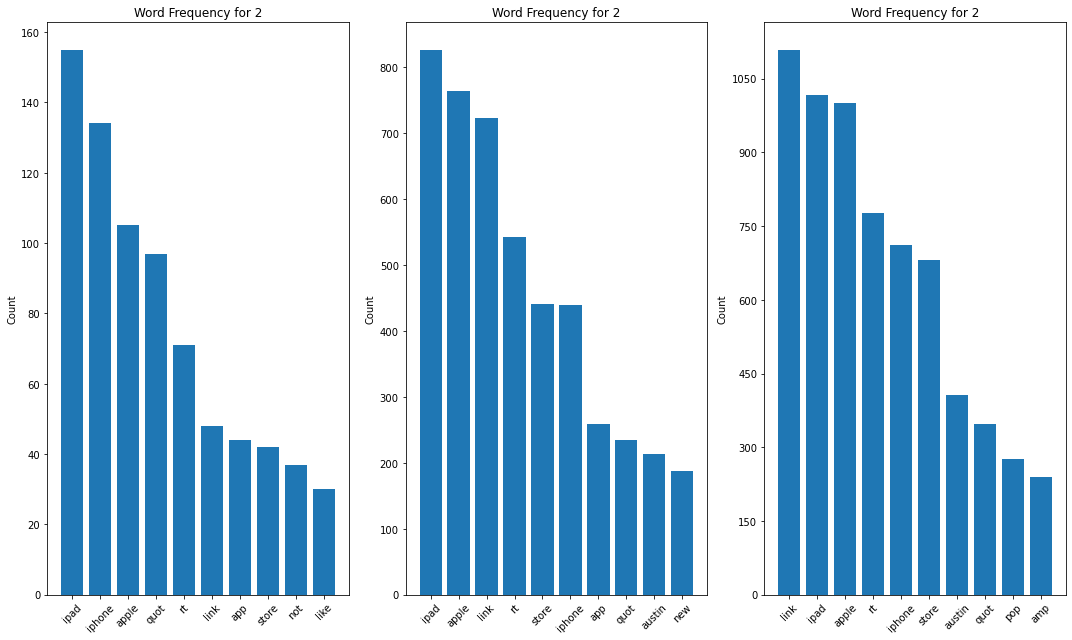

In [468]:
fig, axes = setup_three_subplots()
plot_distribution_of_column_by_category("text_without_stopwords", axes)
fig.suptitle("Word Frequencies without Stopwords", fontsize=24);

In [469]:
tfidf = TfidfVectorizer(
    max_features=10,
    stop_words=stopwords_list)

X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,app,apple,austin,ipad,iphone,link,pop,quot,rt,store
0,0.000000,0.638061,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.769985
1,0.000000,0.000000,0.000000,0.439642,0.000000,0.000000,0.0,0.856843,0.269323,0.000000
2,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,0.735519,0.000000,0.000000,0.000000,0.520149,0.434117,0.0,0.000000,0.000000,0.000000
4,0.000000,0.655959,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.754797,0.000000
...,...,...,...,...,...,...,...,...,...,...
4464,0.000000,0.405836,0.614304,0.000000,0.000000,0.000000,0.0,0.000000,0.466986,0.489746
4465,0.000000,0.000000,0.795682,0.000000,0.605715,0.000000,0.0,0.000000,0.000000,0.000000
4466,0.000000,0.000000,0.000000,0.530459,0.650824,0.543177,0.0,0.000000,0.000000,0.000000
4467,0.000000,0.000000,0.000000,0.698682,0.000000,0.715433,0.0,0.000000,0.000000,0.000000


In [470]:
stopwords_removed_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
stopwords_removed_cv.mean()

0.5444173048643314

In [471]:
print("Baseline:         ", baseline_cv.mean())
print("Stopwords removed:", stopwords_removed_cv.mean())

Baseline:          0.53680903672862
Stopwords removed: 0.5444173048643314


Removing stopwords (with sxsw and mention added) improved accuracy by around 1%.

# Trying Lemmatization to see if it improves model performance.

In [472]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [lemmatizer.lemmatize(token) for token in tokens]


In [473]:
lemmatized_stopwords = [lemmatizer.lemmatize(word) for word in stopwords_list]

In [474]:
tfidf = TfidfVectorizer(
    max_features=10,
    stop_words = lemmatized_stopwords,
    tokenizer = lemmatize_and_tokenize
)

X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,app,apple,austin,ipad,iphone,link,pop,quot,rt,store
0,0.000000,0.640774,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.767729
1,0.000000,0.000000,0.000000,0.439642,0.000000,0.000000,0.0,0.856843,0.269323,0.000000
2,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,0.735558,0.000000,0.000000,0.000000,0.520178,0.434015,0.0,0.000000,0.000000,0.000000
4,0.000000,0.655735,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.754991,0.000000
...,...,...,...,...,...,...,...,...,...,...
4464,0.000000,0.406386,0.615505,0.000000,0.000000,0.000000,0.0,0.000000,0.467899,0.486903
4465,0.000000,0.000000,0.795682,0.000000,0.605715,0.000000,0.0,0.000000,0.000000,0.000000
4466,0.000000,0.000000,0.000000,0.530505,0.650879,0.543067,0.0,0.000000,0.000000,0.000000
4467,0.000000,0.000000,0.000000,0.698785,0.000000,0.715332,0.0,0.000000,0.000000,0.000000


In [475]:
lemmatized_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
lemmatized_cv.mean()

0.5444173048643314

In [476]:
print("Stopwords removed:", stopwords_removed_cv.mean())
print("Lemmatized:          ", lemmatized_cv.mean())

Stopwords removed: 0.5444173048643314
Lemmatized:           0.5444173048643314


Lemmatization offered no improvement in the models accuracy but probably increases efficiency.

# Trying Stemming to see if it improves model performance.

In [477]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language="english")

def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]

In [478]:
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

In [479]:
tfidf = TfidfVectorizer(
    max_features = 10,
    stop_words = stemmed_stopwords,
    tokenizer = stem_and_tokenize
)

X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,app,appl,austin,ipad,iphon,link,pop,quot,rt,store
0,0.000000,0.551049,0.000000,0.510338,0.000000,0.000000,0.0,0.000000,0.000000,0.660227
1,0.000000,0.000000,0.000000,0.435282,0.000000,0.000000,0.0,0.858673,0.270574,0.000000
2,0.854408,0.000000,0.000000,0.519603,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,0.712568,0.000000,0.000000,0.000000,0.538173,0.450130,0.0,0.000000,0.000000,0.000000
4,0.000000,0.655735,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.754991,0.000000
...,...,...,...,...,...,...,...,...,...,...
4464,0.000000,0.406386,0.615505,0.000000,0.000000,0.000000,0.0,0.000000,0.467899,0.486903
4465,0.000000,0.000000,0.796396,0.000000,0.604776,0.000000,0.0,0.000000,0.000000,0.000000
4466,0.000000,0.000000,0.000000,0.525493,0.652615,0.545849,0.0,0.000000,0.000000,0.000000
4467,0.000000,0.000000,0.000000,0.693546,0.000000,0.720413,0.0,0.000000,0.000000,0.000000


In [480]:
stemmed_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)

In [481]:
print("Stopwords removed:", stopwords_removed_cv.mean())
print("Stemmed:          ", stemmed_cv.mean())

Stopwords removed: 0.5444173048643314
Stemmed:           0.5392698868404769


Stemming actually decreased performance of the model so we will not use Stemming in our model.

# Feature engineering - will add number of sentences and whether tweet has an emoji columns

In [482]:
from nltk.tokenize import sent_tokenize

X_train["num_sentences"] = X_train["tweet_text"].apply(lambda x: len(sent_tokenize(x)))

IndexError: list index out of range

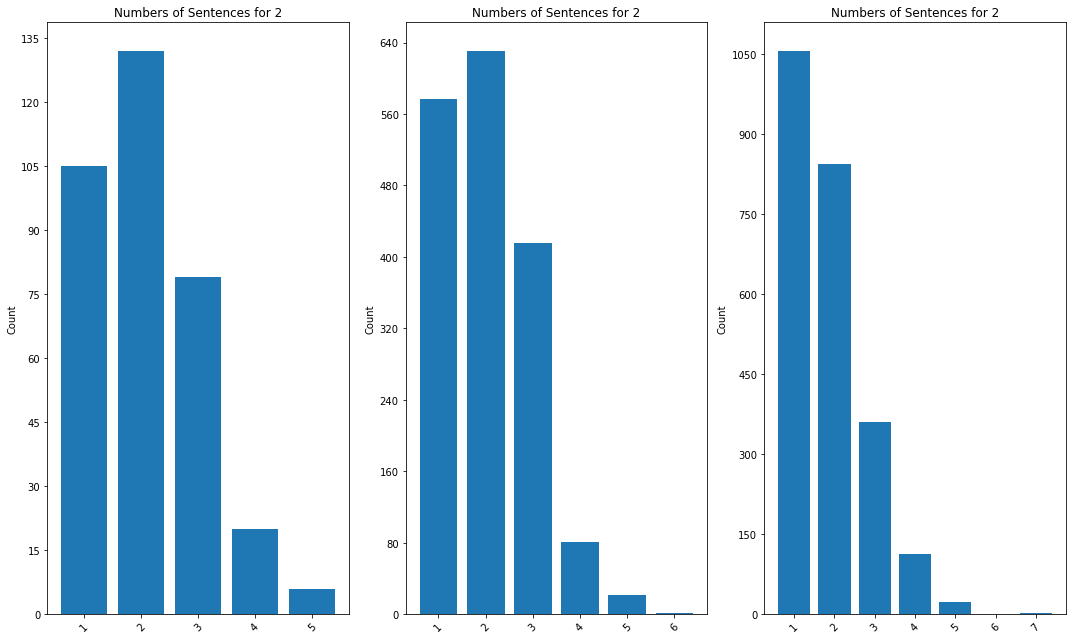

In [483]:
fig, axes = setup_three_subplots()
plot_distribution_of_column_by_category("num_sentences", axes, "Numbers of Sentences for")
fig.suptitle("Distribution of Sentence Counts by Category", fontsize=24);

IndexError: list index out of range

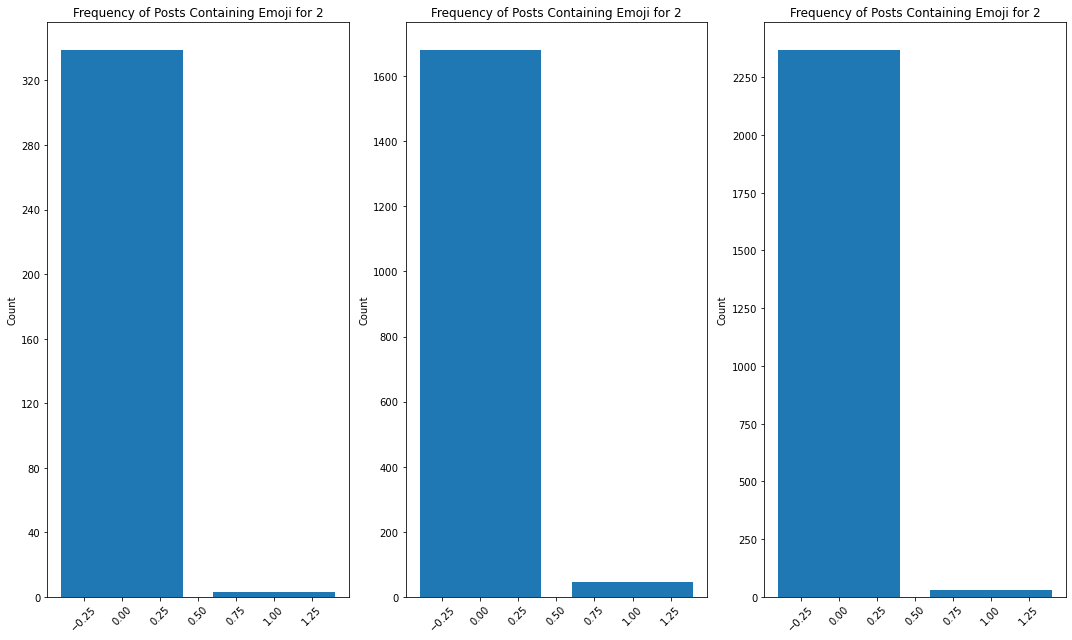

In [484]:
emoji_query = r'(?:[\:;X=B][-^]?[)\]3D([OP/\\|])(?:(?=\s))'

X_train["contains_emoji"] = X_train["tweet_text"].str.contains(emoji_query)

fig, axes = setup_three_subplots()
plot_distribution_of_column_by_category("contains_emoji", axes, "Frequency of Posts Containing Emoji for")
fig.suptitle("Distributions of Posts Containing Emoji by Category", fontsize=24);

It appears that positive posts might contain emoji's at a slightly higher rate which would make sense because a smiley face is probably the most common emoji and it would most likely be in a positive emotion tweet.

In [485]:
tfidf = TfidfVectorizer(
    max_features=10,
    stop_words = lemmatized_stopwords,
    tokenizer = lemmatize_and_tokenize
)

X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

### Concatenating the engineered features in a new DataFrame 'preprocessed_X_train'
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())
#preprocessed_X_train = pd.concat([
    #X_train_vectorized_df, X_train[["num_sentences", "contains_emoji"]]
#], axis = 1,)

#preprocessed_X_train
X_train_vectorized_df = pd.DataFrame(X_train_vectorized.toarray(), columns=tfidf.get_feature_names())

In [486]:
### Concatenating the engineered features in a new DataFrame 'preprocessed_X_train'
preprocessed_X_train = pd.concat([
    X_train_vectorized_df.reset_index(drop=True), X_train[["num_sentences", "contains_emoji"]].reset_index(drop=True)
], axis = 1,)

preprocessed_X_train

,app,apple,austin,ipad,iphone,link,pop,quot,rt,store,num_sentences,contains_emoji
0,0.000000,0.640774,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.767729,1,False
1,0.000000,0.000000,0.000000,0.439642,0.000000,0.000000,0.0,0.856843,0.269323,0.000000,2,False
2,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3,False
3,0.735558,0.000000,0.000000,0.000000,0.520178,0.434015,0.0,0.000000,0.000000,0.000000,3,True
4,0.000000,0.655735,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.754991,0.000000,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
4464,0.000000,0.406386,0.615505,0.000000,0.000000,0.000000,0.0,0.000000,0.467899,0.486903,3,False
4465,0.000000,0.000000,0.795682,0.000000,0.605715,0.000000,0.0,0.000000,0.000000,0.000000,2,False
4466,0.000000,0.000000,0.000000,0.530505,0.650879,0.543067,0.0,0.000000,0.000000,0.000000,1,False
4467,0.000000,0.000000,0.000000,0.698785,0.000000,0.715332,0.0,0.000000,0.000000,0.000000,2,False


In [487]:
preprocessed_cv = cross_val_score(baseline_model, preprocessed_X_train, y_train)

In [488]:
print("Lemmatized:           ", lemmatized_cv.mean())
print("Fully preprocessed:", preprocessed_cv.mean())

Lemmatized:            0.5444173048643314
Fully preprocessed: 0.5482194347785786


- Adding the two engineered features 'num_sentences' and 'contains_emoji' improved accuracy by .5 percent

- Increasing max_features

Vectorizing corpus with max_features=2000 because gridsearch said that was best parameter

In [489]:
tfidf = TfidfVectorizer(
    max_features = 2000,
    stop_words = lemmatized_stopwords,
    tokenizer = lemmatize_and_tokenize
)

X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

X_train_vectorized_df = pd.DataFrame(X_train_vectorized.toarray(), columns=tfidf.get_feature_names())

In [493]:
final_X_train = pd.concat([
    X_train_vectorized_df.reset_index(drop=True), X_train[["num_sentences", "contains_emoji"]].reset_index(drop=True)
], axis=1)
final_X_train

,000,10,100,11,12,13,14,1415,15,16,...,ûªll,ûªm,ûªre,ûªs,ûªt,ûï,ûò,ûó,num_sentences,contains_emoji
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1,False
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2,False
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,3,False
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,3,True
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,3,False
4465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.262891,0.0,0.0,2,False
4466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1,False
4467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2,False


Setting up a pipeline and gridsearch to find the best parameters for our model

In [491]:
final_cv = cross_val_score(baseline_model, final_X_train, y_train)
print("Preprocessed:           ", preprocessed_cv.mean())
print("Final More Features:", final_cv.mean())

Preprocessed:            0.5482194347785786
Final More Features: 0.6151263493590466


-Will use this vectorization in our final MultinomialNB model

In [419]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(apple_df['tweet_text'], apple_df['emotion'], test_size=0.2, random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

# Define the parameter grid
parameter_grid = {
    'tfidf__max_features': [1000, 2000, 3000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'classifier__alpha': [0.1, 0.5, 1.0]
}

# Perform grid search using cross-validation
grid_search = GridSearchCV(pipeline, parameter_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Make predictions on the testing data using the best model
y_pred = grid_search.predict(X_test)

# Evaluate the performance of the best model
report = classification_report(y_test, y_pred)
print(report)

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)


              precision    recall  f1-score   support

           0       1.00      0.08      0.14        77
           1       0.66      0.45      0.54       412
           2       0.66      0.87      0.75       629

    accuracy                           0.66      1118
   macro avg       0.77      0.47      0.48      1118
weighted avg       0.68      0.66      0.63      1118

Best Parameters: {'classifier__alpha': 0.5, 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 1)}
Best Score: 0.6256428948996795


In [494]:
final_model = MultinomialNB(alpha = 0.5)

final_model.fit(final_X_train, y_train)
final_model.score(final_X_train, y_train)

0.7543074513313941

Vectorizing and feature engineering on X_test to perform final evaluation

In [495]:
X_test_vectorized = tfidf.transform(X_test['tweet_text'])

In [496]:
X_test["num_sentences"] = X_test["tweet_text"].apply(lambda x: len(sent_tokenize(x)))
X_test["contains_emoji"] = X_test["tweet_text"].str.contains(emoji_query)

In [497]:
X_test_vectorized_df = pd.DataFrame(X_test_vectorized.toarray(), columns=tfidf.get_feature_names())
final_X_test = pd.concat([
    X_test_vectorized_df.reset_index(drop=True), X_test[["num_sentences", "contains_emoji"]].reset_index(drop=True)
], axis = 1,)
final_X_test

,000,10,100,11,12,13,14,1415,15,16,...,ûªll,ûªm,ûªre,ûªs,ûªt,ûï,ûò,ûó,num_sentences,contains_emoji
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2,False
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,False
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,False
3,0.0,0.0,0.0,0.377873,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3,False
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,False
1114,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2,False
1115,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.373291,0.0,0.0,0.0,0.0,1,False
1116,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,False


In [498]:
final_model.score(final_X_test, y_test)

0.6431127012522362

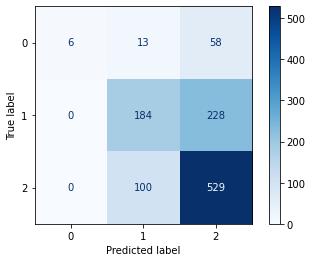

In [500]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cnf_matrix = confusion_matrix(y_test, final_model.predict(final_X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=final_model.classes_)
disp.plot(cmap=plt.cm.Blues);

# Namsoo

# Harshitha

## EDA